In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path_to_file= '/content/gdrive/MyDrive/BRATS2020/Code/BratsDatasetClass.ipynb'
%run "$path_to_file"


# Standard libraries
import os
import time
import gc
import math
import re
import warnings
from random import randint
from itertools import islice
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from scipy import spatial
import torchvision
import torch.nn.functional as torch_func
import torchvision.models as models
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, roc_curve, roc_auc_score


2.0.1+cu118
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content
Stratification time :  0.00540471076965332
train_df -> (202, 12) val_df -> (34, 12) test_df -> (133, 10)
Data preprocessing time :  0.034604549407958984


In [ ]:
def get_augmentations(phase):
    """
    Constructs a composed list of transformations for the given phase.

    Parameters:
    - phase (str): The phase of the process (e.g., 'train', 'test') to determine which set of transformations to return.

    Returns:
    - Compose: A composition of transformations.
    """
    list_transforms = []
    list_trfms = Compose(list_transforms)
    return list_trfms



def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 4 ):
    """
    Returns a DataLoader object for the given dataset and phase.

    Parameters:
    - dataset (torch.utils.data.Dataset): The type of dataset to be used.
    - path_to_csv (str): Path to the CSV file containing the dataset details.
    - phase (str): The phase of the process ('train' or 'valid').
    - fold (int, optional): The fold index for cross-validation. Default is 0.
    - batch_size (int, optional): Number of samples per batch. Default is 1.
    - num_workers (int, optional): Number of subprocesses to use for data loading. Default is 4.

    Returns:
    - DataLoader: DataLoader object for the given dataset and phase.
    """

    df = pd.read_csv(path_to_csv)
    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    if phase == "train" :
        df = train_df
    elif phase == "valid" :
        df = val_df

    dataset = dataset(df, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader

In [ ]:
train_dataloader = get_dataloader(dataset=BratsDataset, path_to_csv=config.root_dir +'train_data.csv', phase='train', fold=0)
val_dataloader = get_dataloader(dataset=BratsDataset, path_to_csv=config.root_dir +'train_data.csv', phase='valid', fold=0)
test_dataloader = get_dataloader(dataset=BratsDataset, path_to_csv=config.root_dir +'train_data.csv', phase='test', fold=0)

print(train_dataloader)

In [ ]:

sample = next(iter(train_dataloader))

In [ ]:
print(sample['Id'])
print(sample['image'].shape)
print(sample['mask'].shape)

['BraTS20_Training_097']
torch.Size([1, 78, 120, 120])
torch.Size([1, 78, 120, 120])


In [ ]:
class ResNetCNN(nn.Module):
    """
    A custom CNN based on a modified ResNet-18 architecture for semantic segmentation tasks.

    This network uses the pretrained ResNet-18 model as a feature extractor, removing the
    global average pooling layer and fully connected layer. The extracted features are
    then upsampled through a series of transposed convolutions to reach the original input size.

    Parameters:
    - in_channels (int): Number of input channels for the model. Default is 1.

    Attributes:
    - resnet_features (nn.Sequential): Extracted layers of ResNet-18 up to the last convolutional block.
    - up1, up2, ..., up6 (nn.Sequential): Upsampling blocks composed of transposed convolutions, batch normalization, and ReLU activations.
    - conv_reduce_dim (nn.Sequential): Convolutional block to reduce dimensions and introduce dropout.
    - conv4 (nn.Conv2d): Final convolutional layer outputting the segmentation mask.

    Forward Input:
    - x (torch.Tensor): The input tensor of shape (batch_size, in_channels, height, width).

    Forward Output:
    - torch.Tensor: The output tensor of shape (batch_size, 1, height, width) representing the predicted segmentation mask.
    """

    def __init__(self, in_channels=1):  # Initialize the model, with a default of 1 input channel.
        super(ResNetCNN, self).__init__()

        # Load the pretrained ResNet-18 model.
        resnet = models.resnet18(pretrained=True)
        # Modify the first convolutional layer of ResNet-18 to accept the given input channels.
        resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Get all layers of ResNet-18 excluding the last two (i.e., without the global average pooling and fully connected layer).
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])

        # Define upsampling layers, each consists of a transpose convolution, batch normalization, and ReLU activation.
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # Up-sample from 512 to 256 channels.
            nn.BatchNorm2d(256),  # Normalize the activations using batch normalization.
            nn.ReLU(inplace=True)  # Apply ReLU activation in-place.
        )

        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.up5 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.up6 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.conv_reduce_dim = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.resnet_features(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        x = self.up5(x)
        x = self.up6(x)

        x = nn.functional.interpolate(x, size=(120, 120), mode='bilinear', align_corners=True)
        x = self.conv_reduce_dim(x)
        x = self.conv4(x)
        return x


In [ ]:
#  TO load the model from last check point
model = ResNetCNN(in_channels=1)
model.load_state_dict(torch.load(config.cnn_model+'/2DImage-ResNet_model_checkpoint.pth'))
model.eval()

In [ ]:
def dice_score(true, preds):
    """
    Compute the Dice similarity coefficient (DSC) between true and predicted binary masks.

    Dice similarity coefficient is a metric used for binary segmentation tasks. It provides a measure of the
    overlap between two binary masks. A value of 1 indicates perfect agreement between two masks, while a value
    of 0 indicates no overlap.

    Parameters:
    - true (torch.Tensor): A tensor of the ground truth binary mask. Shape should match `preds`.
    - preds (torch.Tensor): A tensor of the predicted binary mask. Shape should match `true`.

    Returns:
    - float: The computed Dice similarity coefficient between `true` and `preds`.

    Note:
    An epsilon is added to the denominator and numerator to avoid division by zero.
    """
    tp = (true * preds).sum().to(torch.float32)
    tn = ((1 - true) * (1 - preds)).sum().to(torch.float32)
    fp = ((1 - true) * preds).sum().to(torch.float32)
    fn = (true * (1 - preds)).sum().to(torch.float32)

    epsilon = 1e-7

    dice = (2.0 * tp + epsilon) / (2.0 * tp + fp + fn + epsilon)

    return dice.item()

In [ ]:
def get_best_slice(image: torch.Tensor, mask: torch.Tensor):
    """
    Extract the slice with the highest sum of pixel values from the provided image tensor.

    Parameters:
    - image (torch.Tensor): A tensor containing multiple slices. Shape should be (num_slices, height, width).
    - mask (torch.Tensor): Corresponding tensor with mask slices. Shape should match `image`.

    Returns:
    - tuple(torch.Tensor, torch.Tensor): The slice from the image and its corresponding mask with the highest sum of pixel values.
    """
    slice_sums = image.sum(dim=(1, 2))
    best_slice_idx = torch.argmax(slice_sums)
    grayscale_slice = image[best_slice_idx]
    mask_slice = mask[best_slice_idx]

    return grayscale_slice, mask_slice


def train_updated(model, train_loader, optimizer, epochs=10):
    """
    Train the provided model using the data from train_loader.

    The training process involves forward pass, loss calculation, backpropagation, and
    optimizer step for each batch in the train_loader. Metrics are computed at the end
    of each epoch and a history of these metrics is returned.

    Parameters:
    - model (nn.Module): The neural network model to be trained.
    - train_loader (DataLoader): DataLoader providing the training batches.
    - optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
    - epochs (int, optional): Number of epochs to train the model. Default is 10.

    Returns:
    - dict: Dictionary containing the history of various metrics (Loss, F1-score, Precision, etc.) across epochs.
    - numpy.ndarray: Confusion matrix computed for the final epoch.
    """

    model.train()
    metrics_history = {
        "Loss" : [],
        "f1": [],
        "precision": [],
        "recall": [],
        "accuracy": [],
        "auc": [],
        "dice": []
    }


    for epoch in range(epochs):
        epoch_loss = 0
        all_predictions = []
        all_true_labels = []
        all_probs = []

        for sample in train_loader:
            grayscale_slice, mask_slice = get_best_slice(sample['image'][0], sample['mask'][0])

            # Forward pass
            out = model(grayscale_slice.unsqueeze(0).unsqueeze(0))
            out = torch.sigmoid(out)

            # Generate ground truth label
            y = mask_slice.unsqueeze(0).unsqueeze(0)

            # Calculate loss
            weights = torch.tensor([0.1, 0.9]) # adjust based on your data
            loss = F.binary_cross_entropy(out, y)
            epoch_loss += loss.item()

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Collect predictions, probabilities and ground truths for metrics calculation
            predictions = (out > 0.5).float()
            all_predictions.extend(predictions.view(-1).cpu().numpy())
            all_true_labels.extend(y.view(-1).cpu().numpy())
            all_probs.extend(out.detach().view(-1).cpu().numpy())

        epoch_loss /= len(train_dataloader)

        # Calculate metrics
        f1 = f1_score(all_true_labels, all_predictions)
        precision = precision_score(all_true_labels, all_predictions)
        recall = recall_score(all_true_labels, all_predictions)
        accuracy = accuracy_score(all_true_labels, all_predictions)
        auc = roc_auc_score(all_true_labels, all_probs)
        dice = dice_score(torch.tensor(all_true_labels), torch.tensor(all_predictions))

        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}, AUC: {auc:.4f}, Dice: {dice:.4f}")

        metrics_history["Loss"].append(epoch_loss)
        metrics_history["f1"].append(f1)
        metrics_history["precision"].append(precision)
        metrics_history["recall"].append(recall)
        metrics_history["accuracy"].append(accuracy)
        metrics_history["auc"].append(auc)
        metrics_history["dice"].append(dice)


        cm = confusion_matrix(all_true_labels, all_predictions)



    return metrics_history, cm


In [ ]:
# Define optimizer
opt = optim.Adam(model.parameters(), lr=1e-3)

# Call the updated function to train
metrics_history, cm = train_updated(model, train_dataloader, opt, epochs=40)



Epoch 1, Loss: 0.1696, F1-score: 0.0147, Precision: 0.0772, Recall: 0.0081, Accuracy: 0.9394, AUC: 0.8605, Dice: 0.0147
Epoch 2, Loss: 0.1350, F1-score: 0.0000, Precision: 1.0000, Recall: 0.0000, Accuracy: 0.9444, AUC: 0.9230, Dice: 0.0000
Epoch 3, Loss: 0.1127, F1-score: 0.0001, Precision: 0.3846, Recall: 0.0000, Accuracy: 0.9444, AUC: 0.9535, Dice: 0.0001
Epoch 4, Loss: 0.1035, F1-score: 0.0031, Precision: 0.7622, Recall: 0.0015, Accuracy: 0.9444, AUC: 0.9629, Dice: 0.0031
Epoch 5, Loss: 0.0940, F1-score: 0.4324, Precision: 0.7136, Recall: 0.3102, Accuracy: 0.9547, AUC: 0.9719, Dice: 0.4324
Epoch 6, Loss: 0.0881, F1-score: 0.5928, Precision: 0.7205, Recall: 0.5035, Accuracy: 0.9615, AUC: 0.9766, Dice: 0.5928
Epoch 7, Loss: 0.0848, F1-score: 0.6457, Precision: 0.7244, Recall: 0.5825, Accuracy: 0.9644, AUC: 0.9784, Dice: 0.6457
Epoch 8, Loss: 0.0795, F1-score: 0.6938, Precision: 0.7383, Recall: 0.6544, Accuracy: 0.9679, AUC: 0.9825, Dice: 0.6938
Epoch 9, Loss: 0.0769, F1-score: 0.7194,

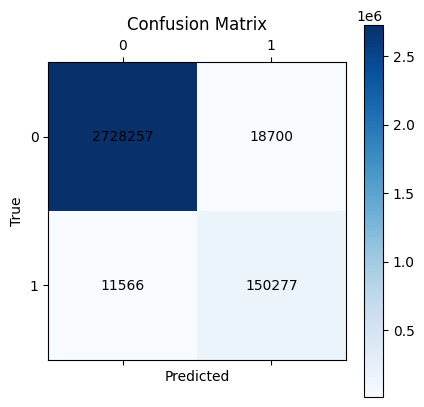

In [ ]:
def plot_confusion_matrix(cm):
    """
    Plot a confusion matrix as a heatmap.

    Parameters:
        cm (numpy.ndarray): Confusion matrix to be plotted.

    Returns:
        None
    """
    # Display the matrix
    plt.matshow(cm, cmap=plt.cm.Blues)
    plt.colorbar()

    # Add title and axis labels
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # Add annotations to the heatmap cells
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center')

    # Use actual class names if given, here we're assuming binary classification as '0' and '1'.
    class_names = ['0', '1']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # Show the plot
    plt.show()


plot_confusion_matrix(cm)


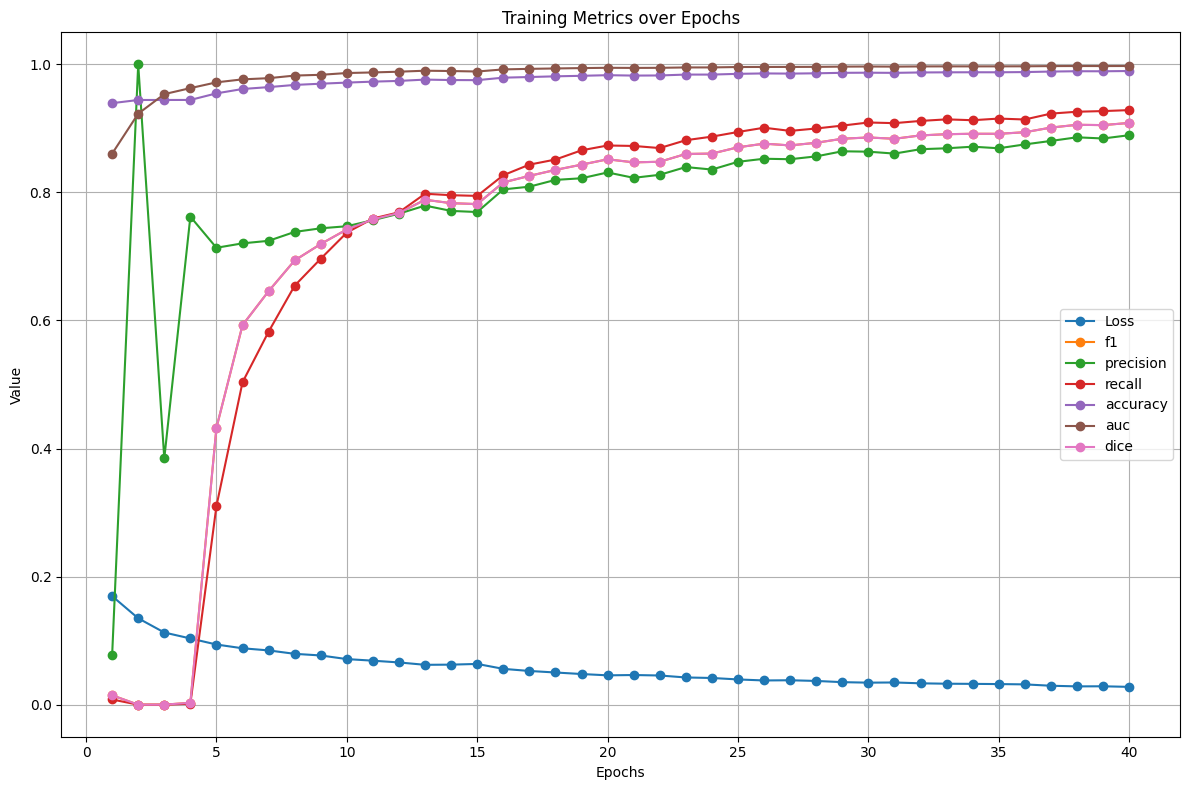

In [ ]:
def plot_metrics(metrics_history: dict):
    """
    Plots a line graph of f1, recall, accuracy, and dice metrics over epochs.

    Parameters:
    - metrics_history (dict): A dictionary containing lists of metric values for each epoch.
                              Should contain keys: "f1", "recall", "accuracy", and "dice".

    Returns:
    - None: Displays the plot.
    """
    epochs = range(1, len(metrics_history["f1"]) + 1)

    plt.figure(figsize=(12, 8))

    for metric, values in metrics_history.items():
        plt.plot(epochs, values, label=metric, marker='o')

    plt.title("Training Metrics over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metrics(metrics_history)

In [ ]:
def validate(model, val_dataloader):
    """
    Validate a model using various metrics on a validation dataset.

    Parameters:
        model (torch.nn.Module): The model to be evaluated.
        val_dataloader: A data loader for the validation dataset.

    Returns:
        tuple: A tuple containing validation loss, F1-score, precision, recall, ROC AUC, accuracy, and Dice coefficient.
    """

    model.eval()

    epoch_loss = 0
    all_predictions = []
    all_true_labels = []
    all_probs = []  # Collecting the probabilities for ROC

    with torch.no_grad():
        for sample in val_dataloader:

            grayscale_slice, mask_slice = get_best_slice(sample['image'][0], sample['mask'][0])

            # Forward pass
            out = model(grayscale_slice.unsqueeze(0).unsqueeze(0))
            out = torch.sigmoid(out)

            # Generate ground truth label
            y = mask_slice.unsqueeze(0).unsqueeze(0)


            # Calculate loss
            loss = F.binary_cross_entropy(out, y)
            epoch_loss += loss.item()

            # Collect predictions and ground truths for metrics calculation
            predictions = (out > 0.5).float()
            all_predictions.extend(predictions.view(-1).cpu().numpy())
            all_true_labels.extend(y.view(-1).cpu().numpy())
            all_probs.extend(out.view(-1).cpu().numpy())  # Append probabilities for ROC

        epoch_loss /= len(val_dataloader)

        # Calculate F1-score, precision, recall
        f1 = f1_score(all_true_labels, all_predictions)
        precision = precision_score(all_true_labels, all_predictions)
        recall = recall_score(all_true_labels, all_predictions)

        # Calculate ROC, Accuracy, Dice Coefficient
        roc = roc_auc_score(all_true_labels, all_probs)
        accuracy = accuracy_score(all_true_labels, all_predictions)
        dice_score = dice_coefficient(torch.tensor(all_true_labels), torch.tensor(all_predictions))

        print(f"Validation Loss: {epoch_loss:.4f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, ROC: {roc:.4f}, Accuracy: {accuracy:.4f}, Dice Score: {dice_score:.4f}")

    return epoch_loss, f1, precision, recall, roc, accuracy, dice_score


In [ ]:
validate(model, val_dataloader)

Validation Loss: 0.1223, F1-score: 0.6857, Precision: 0.6636, Recall: 0.7094, ROC: 0.9640, Accuracy: 0.9619, Dice Score: 0.6857


(0.12229123613317772,
 0.6857065785480662,
 0.6635559761151173,
 0.7093871001499983,
 0.9639663824062676,
 0.9619240196078431,
 tensor(0.6857))

In [ ]:
# saving state of the model
torch.save(model.state_dict(), config.cnn_model+'/2DImage-ResNet_model_checkpoint.pth')


In [ ]:
def get_best_slice(image: torch.Tensor, mask: torch.Tensor = None):
    # image = normalize(image)
    slice_sums = image.sum(axis=(0, 1))
    best_slice_idx = np.argmax(slice_sums)
    grayscale_slice = image[best_slice_idx]

    if mask is not None:
        # mask = normalize(mask)
        mask_slice = mask[best_slice_idx]
        return grayscale_slice, mask_slice
    return grayscale_slice

def predict_with_probabilities(data):
    model.eval()
    grayscale_slice, mask_slice = get_best_slice(sample['image'][0], sample['mask'][0])
    with torch.no_grad():
        predictions = model(grayscale_slice.unsqueeze(0).unsqueeze(0))
    return torch.sigmoid(predictions)

# Test
probabilities = predict_with_probabilities(sample)
print("Raw probabilities:", probabilities)




Raw probabilities: tensor([[[[1.4707e-03, 1.7897e-05, 1.0247e-05,  ..., 1.4270e-05,
           1.0611e-05, 1.5293e-03],
          [1.3373e-05, 1.6800e-08, 7.0120e-09,  ..., 1.5376e-08,
           9.2168e-09, 1.6034e-05],
          [7.1090e-06, 6.9514e-09, 3.1328e-09,  ..., 1.1738e-08,
           6.0655e-09, 1.1921e-05],
          ...,
          [8.5613e-06, 1.0111e-08, 7.3331e-09,  ..., 1.1010e-08,
           6.7055e-09, 1.2204e-05],
          [1.0578e-05, 1.3456e-08, 8.5178e-09,  ..., 1.1404e-08,
           9.3335e-09, 1.6463e-05],
          [1.1144e-03, 1.3366e-05, 1.0614e-05,  ..., 1.1702e-05,
           1.0585e-05, 1.4639e-03]]]])


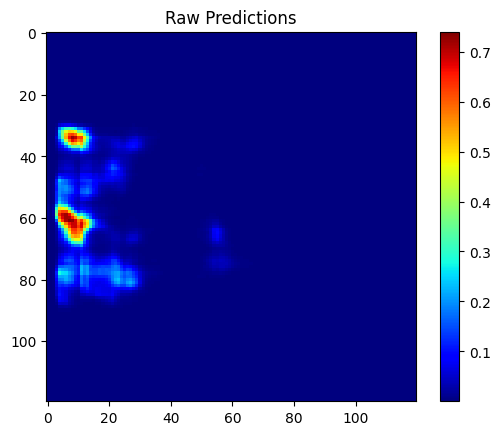

In [ ]:
def visualize_raw_predictions(sample, model):
    grayscale_slice = get_best_slice(sample['image'][0])
    with torch.no_grad():
        raw_predictions = model(grayscale_slice.unsqueeze(0).unsqueeze(0))
    probabilities = torch.sigmoid(raw_predictions)
    plt.imshow(probabilities[0,0,:,:].detach().cpu().numpy(), cmap='jet')
    plt.colorbar()
    plt.title("Raw Predictions")
    plt.show()

# Visualize raw predictions
visualize_raw_predictions(sample, model)


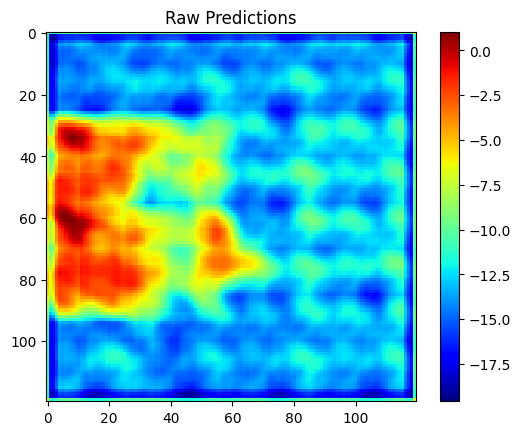

In [ ]:
def visualize_raw_predictions(sample, model):
    grayscale_slice = get_best_slice(sample['image'][0])
    with torch.no_grad():
        raw_predictions = model(grayscale_slice.unsqueeze(0).unsqueeze(0))
    probabilities = raw_predictions
    plt.imshow(probabilities[0,0,:,:].detach().cpu().numpy(), cmap='jet')
    plt.colorbar()
    plt.title("Raw Predictions")
    plt.show()

# Visualize raw predictions
visualize_raw_predictions(sample, model)


Patient ID : ['BraTS20_Training_247']
torch.Size([1, 78, 120, 120])


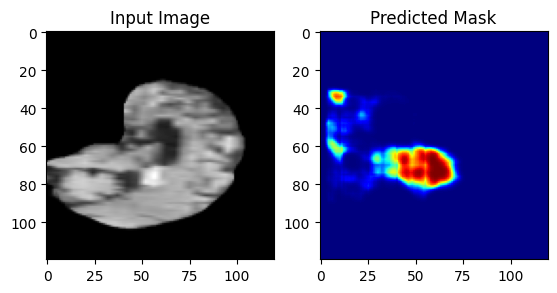

In [ ]:
import matplotlib.pyplot as plt

# Get a sample from the dataloader
sample = next(iter(test_dataloader))
print(f"Patient ID : {sample['Id']}")
print(sample['image'].shape)

# Determine the middle slice index
middle_slice_idx = sample['image'].shape[1] // 2

plt.figure(figsize=(10, 4))

# Visualize the Input Image
plt.subplot(131)
plt.imshow(sample['image'][0,middle_slice_idx, :,:], cmap='gray')
plt.title('Input Image')

# Predict and visualize the Predicted Mask
plt.subplot(132)
grayscale_slice = get_best_slice(sample['image'][0])
grayscale_slice = grayscale_slice.float()  # Convert the tensor to float
y_pred = model(grayscale_slice.unsqueeze(0).unsqueeze(0))
plt.imshow(torch.sigmoid(y_pred)[0,0,:,:].detach().cpu().numpy(), cmap='jet')
plt.title('Predicted Mask')

plt.show()


Patient ID : ['BraTS20_Training_024']
torch.Size([1, 78, 120, 120])


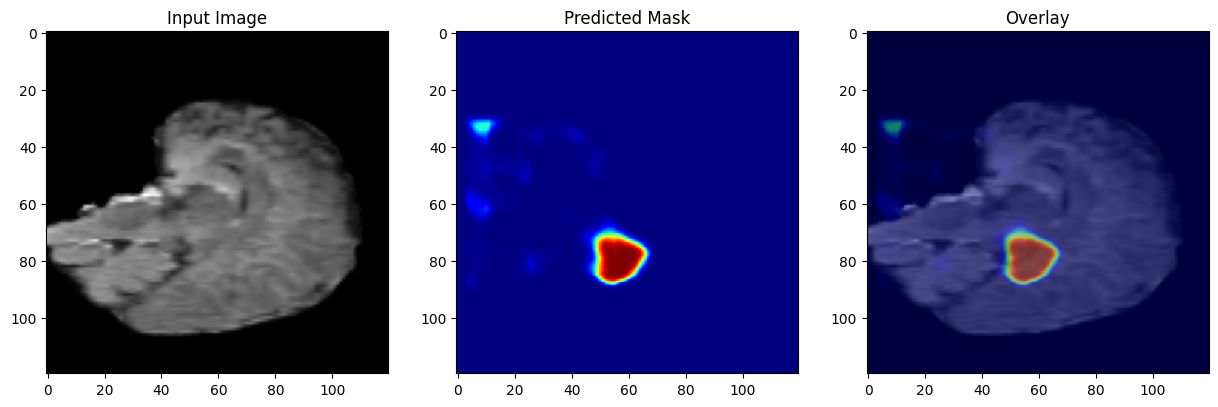

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming you have the 'get_best_slice' function and 'model' defined

# Get a sample from the dataloader
sample = next(iter(test_dataloader))
print(f"Patient ID : {sample['Id']}")
print(sample['image'].shape)

# Determine the middle slice index
middle_slice_idx = sample['image'].shape[1] // 2

plt.figure(figsize=(15, 5))

# Visualize the Input Image
plt.subplot(131)
plt.imshow(sample['image'][0,middle_slice_idx, :, :], cmap='gray')
plt.title('Input Image')

# Get grayscale slice
plt.subplot(132)
grayscale_slice = get_best_slice(sample['image'][0])
grayscale_slice = grayscale_slice.float()  # Convert the tensor to float
y_pred = model(grayscale_slice.unsqueeze(0).unsqueeze(0))
plt.imshow(torch.sigmoid(y_pred)[0,0,:,:].detach().cpu().numpy(), cmap='jet')
plt.title('Predicted Mask')


# Visualize the Overlay
plt.subplot(133)
plt.imshow(sample['image'][0,middle_slice_idx, :, :], cmap='gray')
plt.imshow(torch.sigmoid(y_pred)[0, 0, :, :].detach().cpu().numpy(), cmap='jet', alpha=0.5)
plt.title('Overlay')

plt.show()
